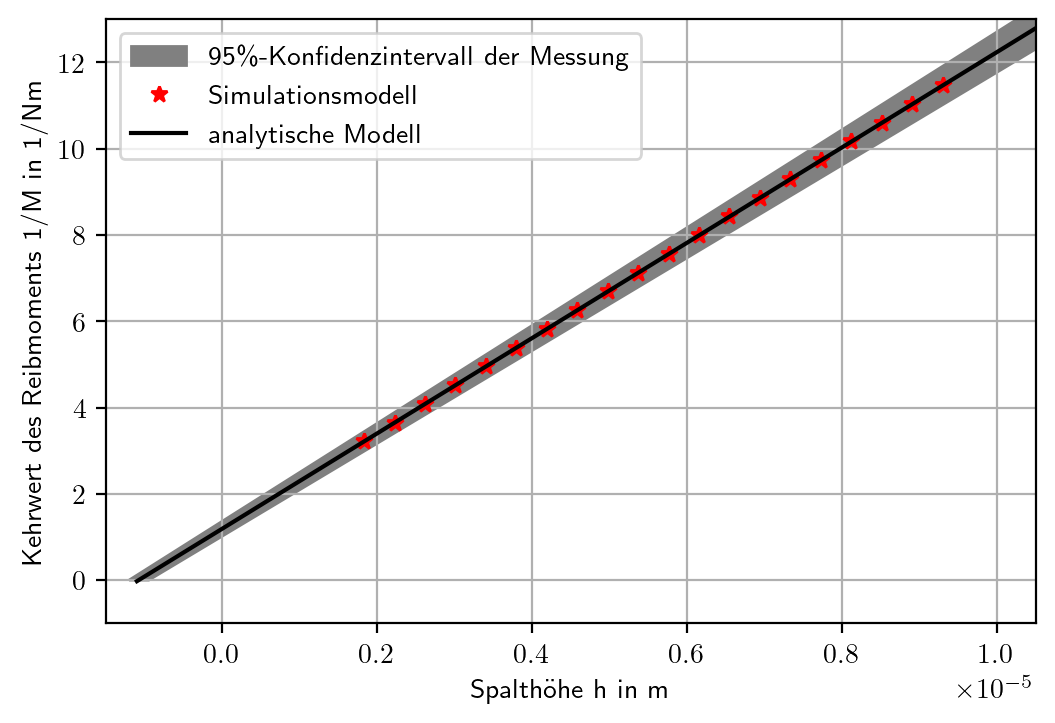

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams

rcParams["figure.dpi"] = 200
rcParams["text.usetex"] = True


#Messdaten

#importieren
data = pd.read_csv("Messdaten_Corneli.csv")
X=data["x"]
Y=data["Curve1"]**(-1)
n=len(X)
#y=a+b*x Fehlerfortpflanzung; y und x sind fehlerbehaftet 
sumX=np.sum(X)
sumY=np.sum(Y)
sumXY=np.sum(X*Y)
sumXX=np.sum(X*X)
sumYY=np.sum(Y*Y)


a=(sumXX*sumY-sumX*sumXY)/(n*sumXX-sumX**2)
b=(n*sumXY-sumX*sumY)/(n*sumXX-sumX**2)
l=a/b/2# Gleitlänge

a_x=np.linspace(0,0,n)#da/dx
a_y=np.linspace(0,0,n)#da/dy
b_x=np.linspace(0,0,n)#db/dx
b_y=np.linspace(0,0,n)#db/dy
s2=0#s**2 statistische Unsicherheit; empirische Varianz
dy=0.04# Messfehler Moment**(-1) 
dx=90e-9# Messfehler Spaltbreite

for i in range(n):
 a_x[i]=(2*X[i]*sumY-(sumXY+Y[i]*sumX))/(n*sumXX-sumX**2)-2*(sumXX*sumY-sumX*sumXY)*(n*X[i]-sumX)/(n*sumXX-sumX**2)**2
 a_y[i]=(sumXX-X[i]*sumX)/(n*sumXX-sumX**2)
 b_x[i]=(n*Y[i]-sumY)/(n*sumXX-sumX**2)-2*(n*sumXY-sumX*sumY)*(n*X[i]-sumX)/(n*sumXX-sumX**2)**2
 b_y[i]=(n*X[i]-sumX)/(n*sumXX-sumX**2)
 s2+=1/(n-1)*(Y[i]-(a+b*X[i]))**2   

da=0
db=0
i=1
for i in range(n):
   da+=(dx**2*a_x[i]**2+(s2+dy**2)*a_y[i]**2)
   db+=(dx**2*b_x[i]**2+(s2+dy**2)*b_y[i]**2)
   for j in range(n):
      if (j==i):
        continue 
      da+=dx**2*a_x[i]*a_y[j]+dy**2*a_y[i]*a_y[j]
      db+=dx**2*b_x[i]*a_y[j]+dy**2*b_y[i]*b_y[j]
da=np.sqrt(da) 
db=np.sqrt(db)       
dl=np.sqrt((1/2/b)**2*da**2+(a/2/b**2)**2*db**2)# Standardabweichung Gleitlänge

height=np.linspace(-1100e-9,12e-6,1000)

#95% Konfidenzintervall
a_max=a+1.96*da
a_min=a-1.96*da
b_min=b-1.96*db
b_max=b+1.96*db
dl=1.96*dl

# 95% Konfidenzintervall zeichnen 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-1500e-9, 1.05e-5)
ax.set_ylim(-1, 13)

x = [-a_max/b_max,-a_min/b_min,height[-1],height[-1],] #x-Koordinate Eckpunkte 
y = [0,0,a_min+b_min*height[-1],a_max+b_max*height[-1]] #y-Koordinaten Eckpunkte

#plt.plot(height,b_max*height+a_max,"k")
#plt.plot(height,b_min*height+a_min,"k")

ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=True,color='gray',label="95\%-Konfidenzintervall der Messung"))
#ax.plot(X,Y,'ko',label="Messpunkte")

#Simulation
#Die Paramter mu und l wurden aus der Messungen extrahiert, um die Simulation zu machen 
#l=a/b/2 / mu=(b*omega*np.pi/2*R**4)**(-1)
post_proc_dir = "Study1(Validierung)/"
ParameterStudies_dir=sorted(os.listdir(post_proc_dir))

#Spaltbreite
CFDheights= np.linspace(1.831e-6, 9.296e-6, 20)
#Moment extrahieren
CFDtorques=[]
for Parameterstudy_dir in ParameterStudies_dir:
    study_path=os.path.join(post_proc_dir,Parameterstudy_dir)
    data_path=os.path.join(study_path,"postProcessing/forces/0/moment.dat")
    torque = pd.DataFrame(pd.read_csv(data_path ,header=None,skiprows=3,delimiter="\t"))
    CFDtorque=torque[0].str.split(" ")
    CFDtorque=1/(180*float(CFDtorque[len(CFDtorque)-1][-1]))
    CFDtorques=np.append(CFDtorques,CFDtorque)

plt.plot(np.transpose(CFDheights),CFDtorques,'r*',label="Simulationsmodell")

    
#analytic
#parameters
R=32e-3
lambdaB=l
lambdaT=l
omega=25.133
mu=(b*omega*np.pi/2*R**4)**(-1)

# analytisches Modell
def calc_analytic_torque(H,R, lambdaB, lambdaT, omega,mu):
    return 1/(np.pi/2*omega*R**4*mu/(H+lambdaB+lambdaT))
analyticTorque=[]
for H in height:
    analyticTorque=np.append(analyticTorque,calc_analytic_torque(H, R, lambdaB, lambdaT, omega,mu))

plt.plot(height,analyticTorque,'k',label="analytische Modell")
plt.grid()
plt.xlabel("Spalthöhe h in m")
plt.ylabel("Kehrwert des Reibmoments 1/M in 1/Nm")
plt.legend()